## Brain Tumor Detection


* [Part I: Classification](#section-one)
* [Part II: Activations' Visualization](#section-two)
* [Part III: Segmentation with U-net](#section-three)
* [Conclusion](#section-four)

<a id="section-one"></a>
## Part I: Classification

In this first part of the notebook, the main aim is to create a model able to distinguish between MRI images of patients affected by a brain tumor and the ones of healthy subjects. To achieve this aim, instead of using a pre-trained model, as done in the other published notebooks, I decided to build a simple Convolutional Neural Network from scratch. Considering that one of the greatest limitations of Deep learning is the interpretability of the models, I wanted to see if a simpler and more interpretable model could achieve or even overcome the results obtained in the other notebooks with deeper models.

P.s: I'm still almost a novice in the field, so feel free to comment or give suggestions to improve or correct the work!

In [1]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#%% IMPORTING DATA

def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        #img = Image.open(filename,'r')
        #IMG = np.array(img)
        sample.append(filename)
    return sample

path1 = '//kaggle/input/brain-tumor-detection/no/*.jpg'
path2 = '//kaggle/input/brain-tumor-detection/yes/*.jpg'
path3 = '//kaggle/input/brain-tumor-detection/pred/*.jpg'

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data.head()

,image,label
0,//kaggle/input/brain-tumor-detection/no/no26.jpg,Healthy
1,//kaggle/input/brain-tumor-detection/no/no979.jpg,Healthy
2,//kaggle/input/brain-tumor-detection/no/no598.jpg,Healthy
3,//kaggle/input/brain-tumor-detection/no/no141.jpg,Healthy
4,//kaggle/input/brain-tumor-detection/no/no715.jpg,Healthy


In [3]:
#%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION)

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

<a id="subsection-one"></a>
### CREATING THE CNN MODEL

In [4]:
#%% CREATING THE CNN MODEL 

import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [5]:
#%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [6]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 28s 103ms/step - loss: 0.6220 - acc: 0.6578 - val_loss: 0.5432 - val_acc: 0.7200
Epoch 2/50
270/270 [==============================] - 13s 49ms/step - loss: 0.5357 - acc: 0.7463 - val_loss: 0.4781 - val_acc: 0.7667
Epoch 3/50
270/270 [==============================] - 13s 49ms/step - loss: 0.4421 - acc: 0.8030 - val_loss: 0.3390 - val_acc: 0.8733
Epoch 4/50
270/270 [==============================] - 14s 51ms/step - loss: 0.3511 - acc: 0.8593 - val_loss: 0.2563 - val_acc: 0.9200
Epoch 5/50
270/270 [==============================] - 13s 48ms/step - loss: 0.2571 - acc: 0.9033 - val_loss: 0.1693 - val_acc: 0.9567
Epoch 6/50
270/270 [==============================] - 14s 50ms/step - loss: 0.1839 - acc: 0.9356 - val_loss: 0.1062 - val_acc: 0.9700
Epoch 7/50
270/270 [==============================] -

In [7]:
#%% CHEKING THE CROSS VALIDATION METRICS

def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.996666669845581
Val_Acc Folder 1 = 0.9900000095367432
Val_Acc Folder 2 = 0.996666669845581


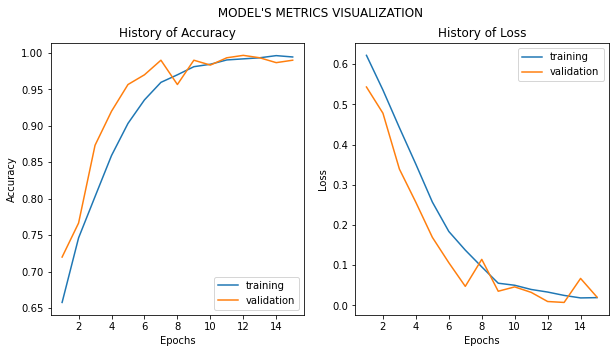

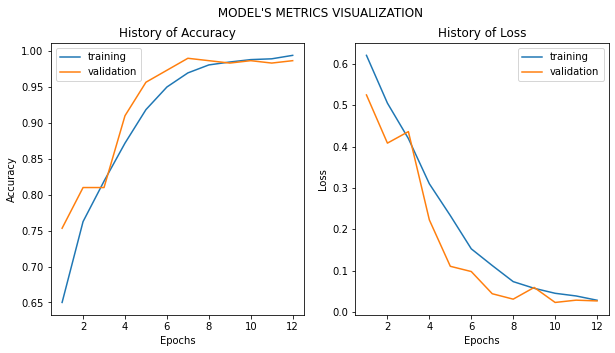

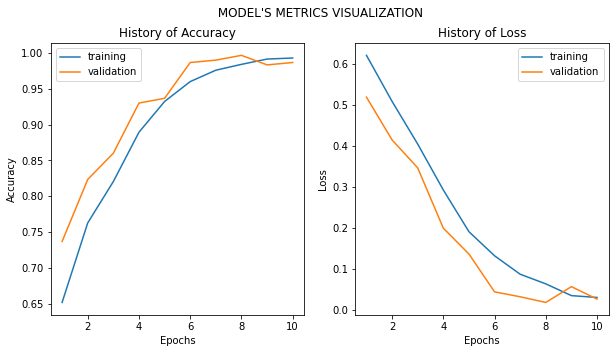

In [8]:
#%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [9]:
#%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)


Found 60 validated image filenames.
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0
 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1]


In [10]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy']


In [19]:
#%% OBTAINING PREDICTIONS OF THE FIRST BATCH
    
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

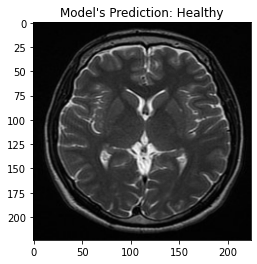

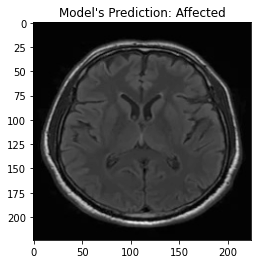

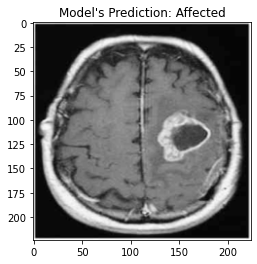

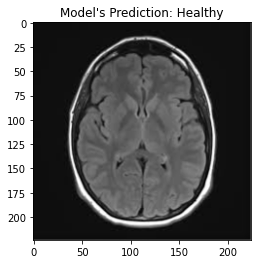

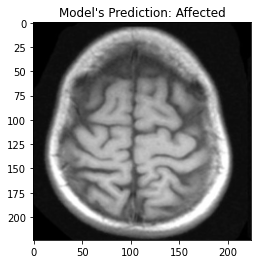

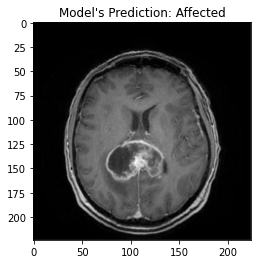

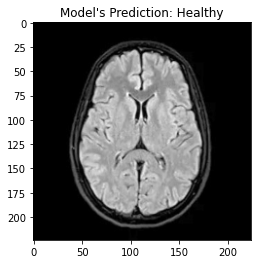

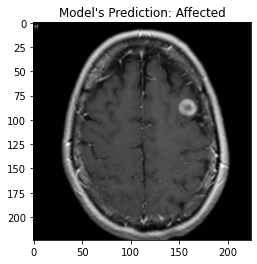

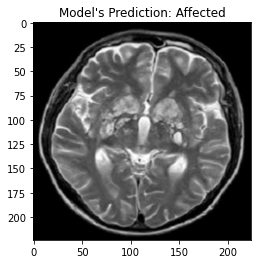

In [20]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)

<a id="section-two"></a>
### CAM - VISUALIZATION 

In this second part of the notebook, the idea is to see where the network focuses its attention during decision processing. This is done by looking at the class activation maps (CAM).

In [21]:
#%% IMPORTING LIBRARIES

import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image

Code adapted from: https://keras.io/examples/vision/grad_cam/

In [22]:
layer_names = [layer.name for layer in keras_model.layers]
layer_names

['conv2d_12',
 'max_pooling2d_6',
 'conv2d_13',
 'conv2d_14',
 'conv2d_15',
 'max_pooling2d_7',
 'flatten_3',
 'dense_9',
 'dropout_6',
 'dense_10',
 'dropout_7',
 'dense_11']

In [23]:
#%% CREATING THE HEATMAP FROM THE LAYERS' ACTIVATIONS

img_size = (224, 224)
layer_names=[layer.name for layer in keras_model.layers]

last_conv_layer_name = 'conv2d_15'
classifier_layer_names = [
    'max_pooling2d_7',
    'flatten_3',
    'dense_9',
    'dropout_6',
    'dense_10',
    'dropout_7',
    'dense_11']

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    
    #img_array = test_set[0][8]
    img_array = img_array.reshape(1,224,224,1)
    img_array = img_array[:1]
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1,2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


In [24]:
#%% DEFINING A FUNCTION TO DISPLAY THE HEATMAP ON THE REAL IMAGE

def display(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.005 + img.reshape(224,224,1)  #img_array.reshape(224,224,1)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

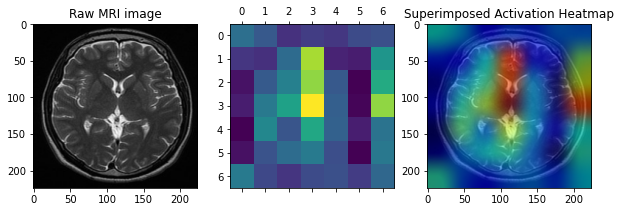

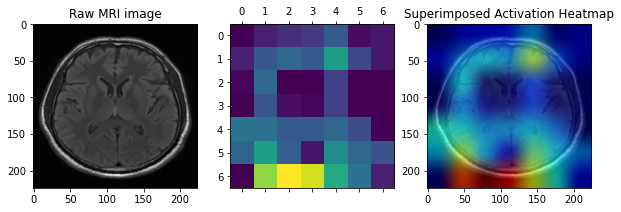

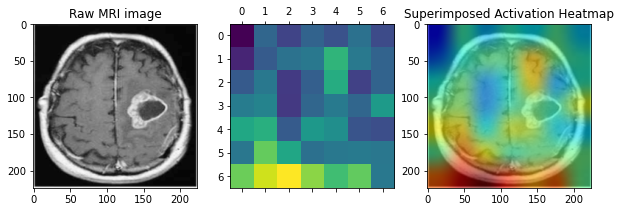

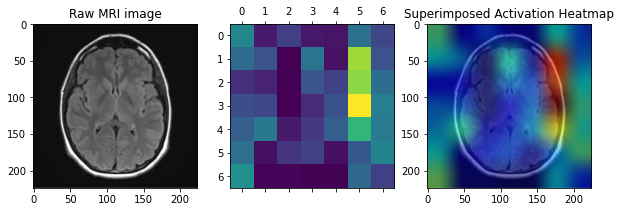

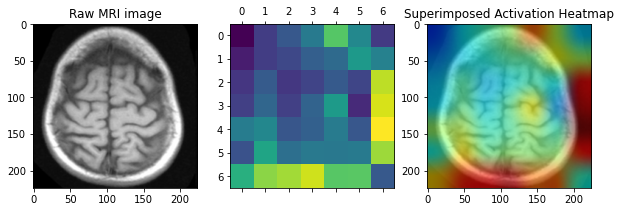

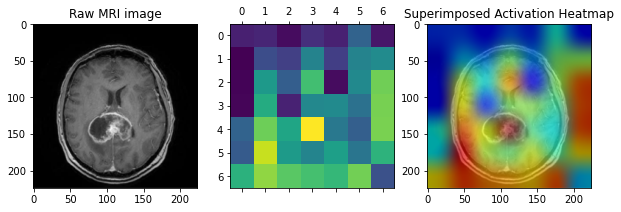

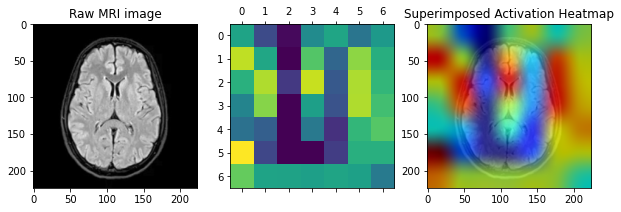

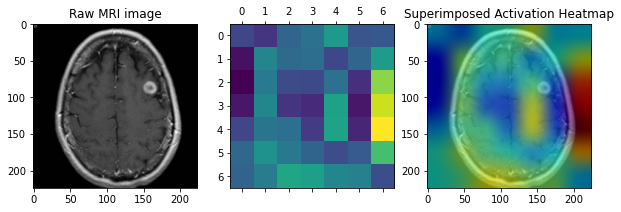

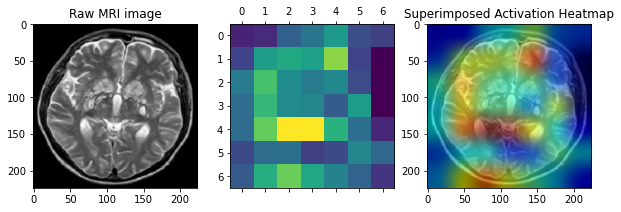

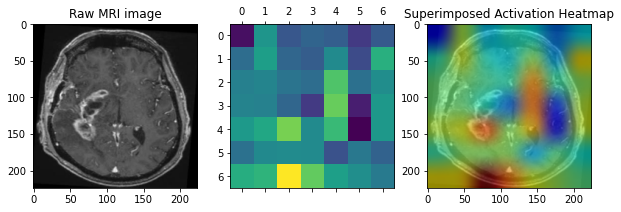

In [25]:
#%% OBSERVING THE RAW IMAGE, THE HEATMAP AND THE SUPERIMPOSED IMAGES TOGETHER

for img in images10:
    heatmap = make_gradcam_heatmap(img,
                                   keras_model,
                                   last_conv_layer_name,
                                   classifier_layer_names)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (10,5))
    
    ax1.imshow(img.reshape(224,224), cmap = 'gray')
    ax1.set_title('Raw MRI image')
    ax2.matshow(heatmap)
    ax3.imshow(display(heatmap,img))
    ax3.set_title('Superimposed Activation Heatmap')

<a id="section-three"></a>
### Part II: Tumor Segmentation using U-net

WORK IN PROGRESS

<a id="section-four"></a>
### Conclusion

**Part I:**

The first section of this work underlines how a simple convolutional neural network performs better than its more complex and already implemented counterparts. A result that is probably due to the easiness of the task. Considering the high similarity among the images, founding the tumoral patterns seems not too hard for the model. Then, we could say that this is a perfect example of the: "less is more" saying.